In [ ]:
import pandas as pd

df = pd.read_csv('data/stock/UNIP3.SA.csv')

df = df[['Date', 'Close']]

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])
import numpy as np
# a variavel clse vai ser o consumo !!!!!!!!!!
window_size = 1 # quantos dias anteriores serão usados para prever o próximo dia
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], [] # variaveis independentes X  e dependentes Y
#
  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy() # vai ser o consumo
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=window_size)
windowed_df
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=window_size)
dates, X, y = windowed_df_to_date_X_y(windowed_df)
model = Sequential([layers.Input((window_size, 1)),
                    layers.LSTM(70),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-19,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
1,2000-01-20,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
2,2000-01-21,3.290000,3.290000,2.733273,2.733273,1.107144,0.0
3,2000-01-24,3.290000,3.290000,2.530773,2.530773,1.025119,0.0
4,2000-01-25,2.530773,2.530773,2.530773,2.530773,1.025119,0.0
...,...,...,...,...,...,...,...
5812,2023-03-08,75.000000,75.980003,74.699997,75.599998,75.599998,10500.0
5813,2023-03-09,75.500000,75.610001,75.059998,75.199997,75.199997,8800.0
5814,2023-03-10,75.199997,75.330002,73.500000,74.510002,74.510002,25600.0
5815,2023-03-13,74.510002,74.510002,72.519997,73.000000,73.000000,26700.0


1/1 [==============================] - 0s 67ms/step


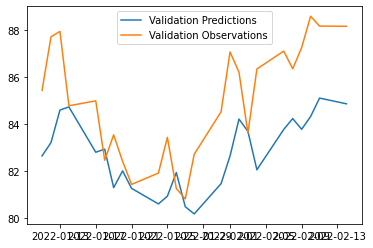

In [14]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 59ms/step


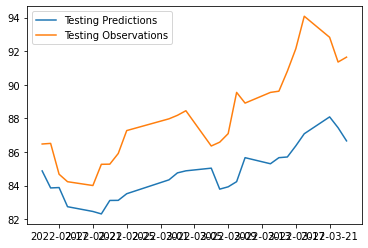

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

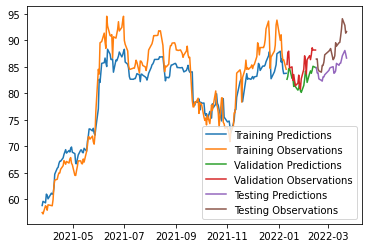

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [18]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 112ms/step


array([[[56.80909 ]],

       [[57.53636 ]],

       [[57.272728]],

       [[58.81818 ]],

       [[58.627274]],

       [[57.97273 ]],

       [[58.99091 ]],

       [[58.845455]],

       [[58.80909 ]],

       [[59.954544]],

       [[62.5     ]],

       [[63.636364]],

       [[63.80909 ]],

       [[64.545456]],

       [[65.      ]],

       [[65.      ]],

       [[65.681816]],

       [[66.36363 ]],

       [[67.34545 ]],

       [[66.63636 ]],

       [[67.163635]],

       [[66.86363 ]],

       [[67.61818 ]],

       [[67.89091 ]],

       [[66.818184]],

       [[66.527275]],

       [[64.545456]],

       [[64.527275]],

       [[65.454544]],

       [[66.25455 ]],

       [[67.27273 ]],

       [[67.27273 ]],

       [[66.77273 ]],

       [[66.70909 ]],

       [[67.62727 ]],

       [[67.045456]],

       [[69.06364 ]],

       [[70.163635]],

       [[71.80909 ]],

       [[71.79091 ]],

       [[71.36363 ]],

       [[71.94546 ]],

       [[70.87273 ]],

       [[70

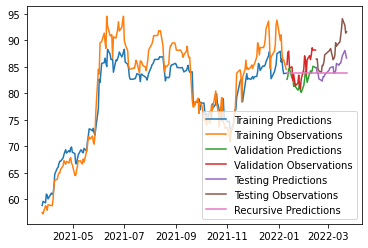

In [19]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [20]:
import plotly.express as px
df_fig = pd.DataFrame({'pred':test_predictions,'real':y_test})
df_fig.index = dates_test

fig = px.line(df_fig,x=df_fig.index,y=['pred','real'])
fig.show()

In [190]:
df_fig

,pred,real
2022-02-15,28.225185,26.400000
2022-02-16,26.581497,26.510000
2022-02-17,26.717655,24.959999
2022-02-18,24.781639,24.639999
2022-02-21,24.377808,24.740000
2022-02-22,24.504135,24.910000
2022-02-23,24.718624,23.700001
2022-02-24,23.185137,23.500000
2022-02-25,22.930334,25.100000
2022-03-02,24.957920,27.129999


# Production

In [ ]:
model.predict(np.array([[[74.11]],[[75.1]],[[66]]])) #prod structure



1/1 [==============================] - 0s 68ms/step


array([[75.183136],
       [75.966934],
       [68.1463  ]], dtype=float32)

Epoch 1/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 172.8739 - mean_absolute_error: 13.0180 - val_loss: 126.5966 - val_mean_absolute_error: 11.2362
Epoch 2/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 164.5342 - mean_absolute_error: 12.7004 - val_loss: 116.7411 - val_mean_absolute_error: 10.7889
Epoch 3/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 151.6520 - mean_absolute_error: 12.1777 - val_loss: 103.3030 - val_mean_absolute_error: 10.1469
Epoch 4/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 135.0952 - mean_absolute_error: 11.4787 - val_loss: 85.6811 - val_mean_absolute_error: 9.2378
Epoch 5/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 108.5939 - mean_absolute_error: 10.2759 - val_loss: 63.9443 - val_mean_absolute_error: 7.9748
Epoch 6/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 86.6361 - mean_absolute_error: 9.1106 - val_loss: 40.5721 - val_mean_absolute_error: 6.3420
Epoch 7/65
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 56.8346 - mean_absolute_error: 7.

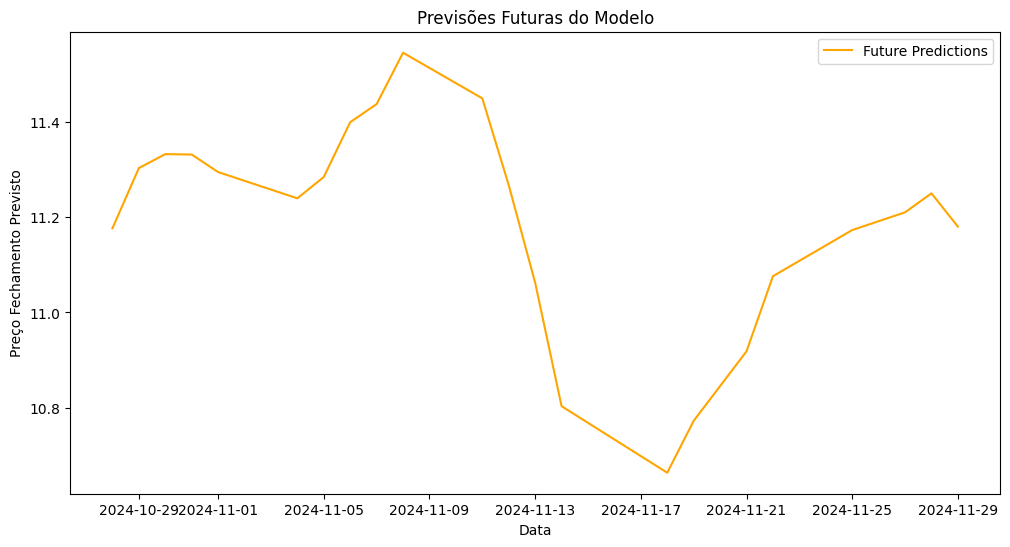

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# Buscar preços reais
import plotly.graph_objects as go



def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)



def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Erro: Janela de tamanho {n} é muito grande para a data {target_date}')
            return None

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break

        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date
        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')

    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    
    return start_date, end_date


def windowed_df_to_date_X_y(windowed_dataframe):
    if windowed_dataframe is None or windowed_dataframe.empty:
        raise ValueError("O DataFrame de janela está vazio ou é None. Verifique as entradas.")

    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)



def train_model(ticker, start_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period='max')
    df = df[['Close']]
    

    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()


    start_date = pd.to_datetime(start_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()

    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

    windowed_df = df_to_windowed_df(df, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), n=window_size)

    if windowed_df is None or windowed_df.empty:
        raise ValueError("Erro: df_to_windowed_df retornou um DataFrame vazio ou None.")

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    model = Sequential([
        layers.Input((window_size, 1)),
        layers.LSTM(70),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=65)

    return model, dates_test, X_test


ticker = 'CSNA3.SA'
start_date = '2024-01-08'
end_date = '2024-11-29'
window_size = 5

model, dates_test, X_test = train_model(ticker, start_date, end_date, window_size)


future_predictions = model.predict(X_test).flatten()


plt.figure(figsize=(12, 6))
plt.plot(dates_test, future_predictions, label='Future Predictions', color='orange')
plt.title('Previsões Futuras do Modelo')
plt.xlabel('Data')
plt.ylabel('Preço Fechamento Previsto')
plt.legend()
plt.show()
#=============== in case you have the data
def get_actual_prices(ticker, start_date, end_date):
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).normalize()
    return df


# Buscar preços reais
actual_prices_df = get_actual_prices(ticker, start_date, end_date)
actual_dates = actual_prices_df.index
actual_prices = actual_prices_df['Close'].to_numpy()

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=dates_test,
    y=future_predictions,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))


fig.add_trace(go.Scatter(
    x=actual_dates,
    y=actual_prices,
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
))


fig.update_layout(
    title='Comparação entre Previsões e Preços Reais',
    xaxis_title='Data',
    yaxis_title='Preço Fechamento',
    legend=dict(x=0, y=1),
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)


fig.show()


Working as feeding loop state

In [116]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import plotly.graph_objects as go

# Função para ajustar datas disponíveis no DataFrame
def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')
    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    return start_date, end_date

# Função para criar janelas de dados
def create_windows(data, window_size):
    X, dates = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        dates.append(data.index[i + window_size])
    return np.array(X), dates

def train_model(ticker, start_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period="max")
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()
    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)

    data = df.loc[start_date:end_date, 'Close']
    X, _ = create_windows(data, window_size)

    model = Sequential([
        layers.Input((window_size, 1)),
        layers.LSTM(70),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.001),
        metrics=['mean_absolute_error']
    )
    model.fit(X[:, :, np.newaxis], data[window_size:], epochs=65, verbose=1)
    return model, data

# Parâmetros do modelo
ticker = 'KLBN4.SA'
start_date = '2021-11-22'
end_date = '2024-10-27'
window_size = 5


model, data = train_model(ticker, start_date, end_date, window_size)

predictions = []
current_window = data[-window_size:].values
for _ in range(10):  # days ahead
    pred = model.predict(current_window[np.newaxis, :, np.newaxis]).flatten()[0]
    predictions.append(pred)
    current_window = np.append(current_window[1:], pred)


future_dates = [data.index[-1] + datetime.timedelta(days=i+1) for i in range(len(predictions))]
predicted_series = pd.Series(predictions, index=future_dates)

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=data.index,
    y=data,
    mode='lines',
    name='Dados Históricos',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=predicted_series.index,
    y=predicted_series.values,
    mode='lines',
    name='Predições Futuras',
    line=dict(color='orange')
))

fig.update_layout(
    title='Continuação de Preços Previstos',
    xaxis_title='Data',
    yaxis_title='Preço Fechamento',
    legend=dict(x=0, y=1),
    template='plotly_dark',
    hovermode='x unified',
    width=1000,
    height=600
)

fig.show()


Data final ajustada para 2024-10-28 00:00:00
Epoch 1/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.3007 - mean_absolute_error: 1.8762
Epoch 2/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1450 - mean_absolute_error: 0.3203
Epoch 3/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0325 - mean_absolute_error: 0.1488
Epoch 4/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - mean_absolute_error: 0.1347
Epoch 5/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mean_absolute_error: 0.1316
Epoch 6/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - mean_absolute_error: 0.1242
Epoch 7/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - mean_absolute_error: 0.1107
Epoch 8/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.1072
Epoch 9/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0982
Epoch 10/65
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0925
Epoc

PARALLEL VALIDATION

In [117]:
from datetime import datetime, timedelta
import plotly.express as px
df = yf.Ticker(ticker).history(start=end_date, end=str(datetime.strptime(end_date, '%Y-%m-%d')+ timedelta(days=5)).split(' ')[0])

fig = px.line(df,x=df.index,y='Close')
fig.add_trace(go.Scatter(
    x=predicted_series.index,
    y=predicted_series.values,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))
fig.show()


### ASSURING THE DENSE NEURAL NETWORK WILL SEPARE TRAIN, VAL AND TEST SETS PROPERLY

(for application)

Epoch 1/50


c:\Users\OtavioDaflon\Documents\findash\fin_dash_env.yml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3954 - mean_absolute_error: 1.1931 - val_loss: 0.9330 - val_mean_absolute_error: 0.9453
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.0977 - val_loss: 0.4641 - val_mean_absolute_error: 0.6614
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - mean_absolute_error: 0.0811 - val_loss: 0.0637 - val_mean_absolute_error: 0.2104
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0742 - val_loss: 0.1123 - val_mean_absolute_error: 0.3066
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0623 - val_loss: 0.0393 - val_mean_absolute_error: 0.1598
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0619 - val_loss: 0.0164 - val_mean_absolute_error: 0.1043
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - mean_absolute_error: 0.0592 - val_loss: 0.

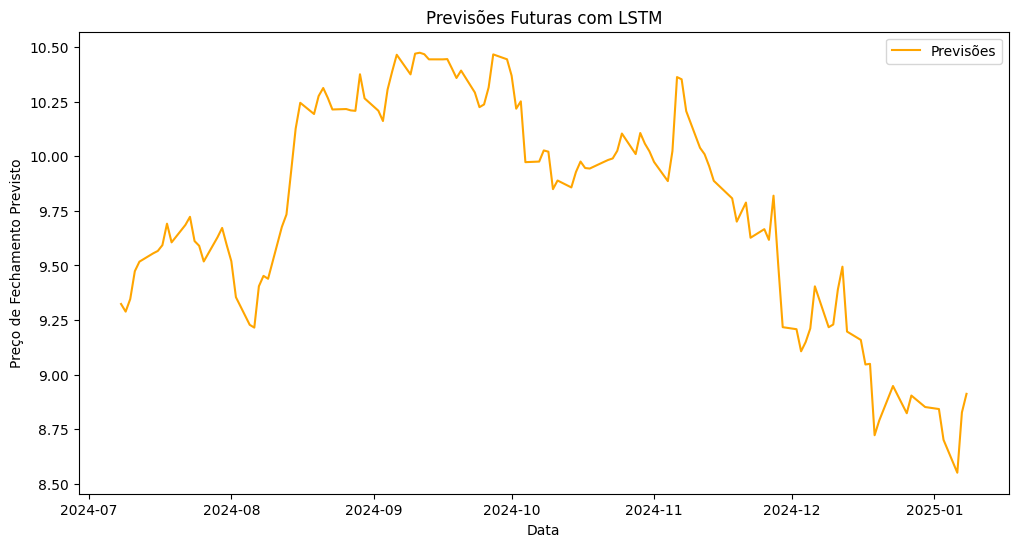

In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import plotly.graph_objects as go

def adjust_dates_to_available(df, start_date, end_date):
    if start_date not in df.index:
        start_date = df.index[df.index.get_indexer([start_date], method='nearest')[0]]
        print(f'Data inicial ajustada para {start_date}')
    if end_date not in df.index:
        end_date = df.index[df.index.get_indexer([end_date], method='nearest')[0]]
        print(f'Data final ajustada para {end_date}')
    return start_date, end_date


# early division
def split_data_temporally(dataframe, train_end_date, val_end_date):
    """Divide os dados respeitando a sequência temporal."""
    train = dataframe.loc[:train_end_date]
    val = dataframe.loc[train_end_date:val_end_date]
    test = dataframe.loc[val_end_date:]
    
    return train, val, test


# windows limited for each individual df
def create_windowed_data(df, window_size):
    """Cria dados em janelas para LSTM."""
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].values)
        y.append(df.iloc[i + window_size])
    return np.array(X), np.array(y)



def train_model(ticker, start_date, train_end_date, val_end_date, end_date, window_size):
    df = yf.Ticker(ticker).history(period='max')
    df = df[['Close']]
    df.index = pd.to_datetime(df.index).tz_convert(None).normalize()

    start_date, end_date = adjust_dates_to_available(df, start_date, end_date)
    start_date = pd.to_datetime(start_date).normalize()
    train_end_date = pd.to_datetime(train_end_date).normalize()
    val_end_date = pd.to_datetime(val_end_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()
    
    train_df, val_df, test_df = split_data_temporally(df, train_end_date, val_end_date)
    
    X_train, y_train = create_windowed_data(train_df['Close'], window_size)
    X_val, y_val = create_windowed_data(val_df['Close'], window_size)
    X_test, y_test = create_windowed_data(test_df['Close'], window_size)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential([
        layers.LSTM(70, input_shape=(window_size, 1)),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
    
    return model, test_df.index[window_size:], X_test

#=============================
# Parameters
ticker = 'ITSA4.SA'
start_date = '2023-01-01'
train_end_date = '2023-12-31'
val_end_date = '2024-06-30'
end_date = '2024-11-29'
window_size = 5
#=============================
model, test_dates, X_test = train_model(ticker, start_date, train_end_date, val_end_date, end_date, window_size)

future_predictions = model.predict(X_test).flatten()


plt.figure(figsize=(12, 6))
plt.plot(test_dates, future_predictions, label='Previsões', color='orange')
plt.title('Previsões Futuras com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Previsto')
plt.legend()
plt.show()


In [3]:
# parallel validation

from datetime import datetime, timedelta
import plotly.express as px
df = yf.Ticker(ticker).history(start=test_dates[0], end=test_dates[-1])

fig = px.line(df,x=df.index,y='Close')
fig.add_trace(go.Scatter(
    x=test_dates,
    y=future_predictions,
    mode='lines',
    name='Future Predictions',
    line=dict(color='orange')
))
fig.show()